In [53]:
import warnings
warnings.filterwarnings('ignore')

### preprocess.py:

In [14]:
import pandas as pd
import config
# we just read the file
# format it in a ML-able format, rough approach here
# just to get my hands dirsty with Flask
df = pd.read_csv(config.train_data)
df = df[config.numerical_cols]
df = df.dropna()
df = df.reset_index(drop=True)
df = pd.get_dummies(df, columns=["Embarked"], drop_first=True)
# apparently using k-1 dummies for k categories is better. When? I guess all the time? ;)
df.to_csv(config.processed_data, index=False)

### train.py:

In [15]:
import pandas as pd
import config
from sklearn.ensemble import RandomForestClassifier
import joblib
# training a simple sklearn model
df = pd.read_csv(config.processed_data)
x = df[df.columns.difference(["Survived"])]
y = df["Survived"]
classifier = RandomForestClassifier()
classifier.fit(x, y)
print("Training complete.")
# persisting the model to a file
joblib.dump(classifier, config.model_store + "RandomForestDefault.pkl")

Training complete.


['./models/RandomForestDefault.pkl']

In [6]:
x.columns

Index(['Age', 'Embarked_Q', 'Embarked_S', 'Fare', 'Parch', 'Pclass', 'SibSp'], dtype='object')

    We have 7 columns above, s`o we will need to enter 7 fields in our little Flask app.

### Some visualizations to help decide app parameters:

In [16]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

512.3292

In [24]:
x.columns

Index(['Age', 'Embarked_Q', 'Embarked_S', 'Fare', 'Parch', 'Pclass', 'SibSp'], dtype='object')

c:\Users\kaush\anaconda3\envs\flask_deploy\lib\site-packages\seaborn\_stats\counting.py:137: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  bin_edges = np.histogram_bin_edges(vals, bins, binrange, weight)
c:\Users\kaush\anaconda3\envs\flask_deploy\lib\site-packages\seaborn\_stats\counting.py:176: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  hist, edges = np.histogram(vals, **bin_kws, weights=weights, density=density)
c:\Users\kaush\anaconda3\envs\flask_deploy\lib\site-packages\seaborn\_stats\counting.py:137: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  bin_edges = np.histogram_bin_edges(vals, bins, binrange, weight)
c:\Users\kaush\anaconda3\envs\flask_deploy\lib\site-packages\seaborn\_stats\counting.py:176: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  hist, edges = np.histogram(vals, **bin_kws, weights=weights, den

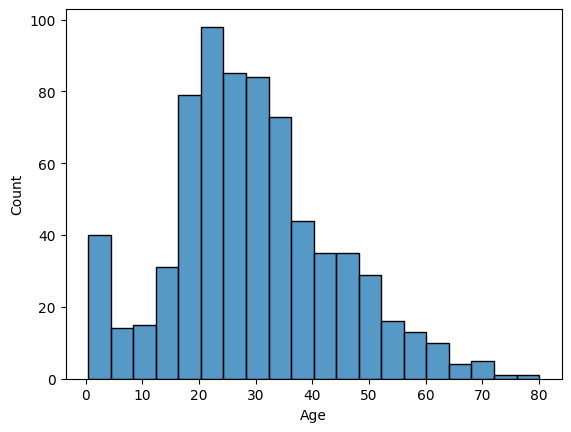

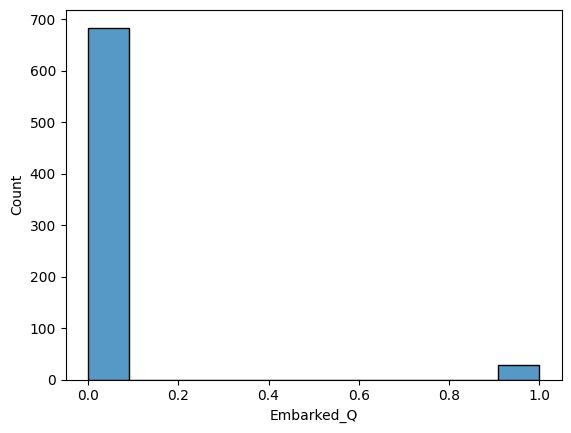

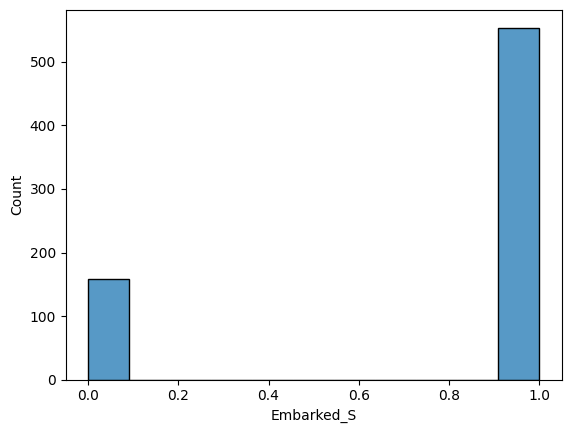

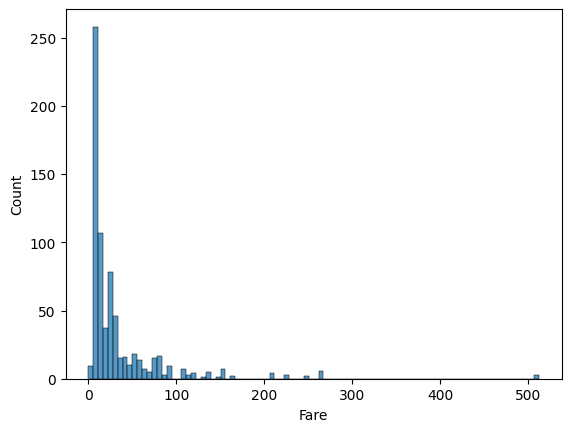

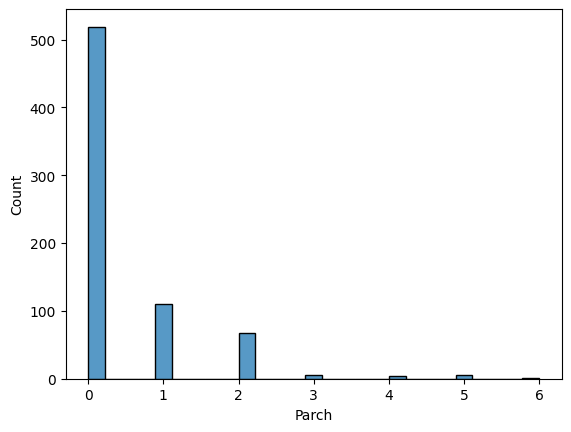

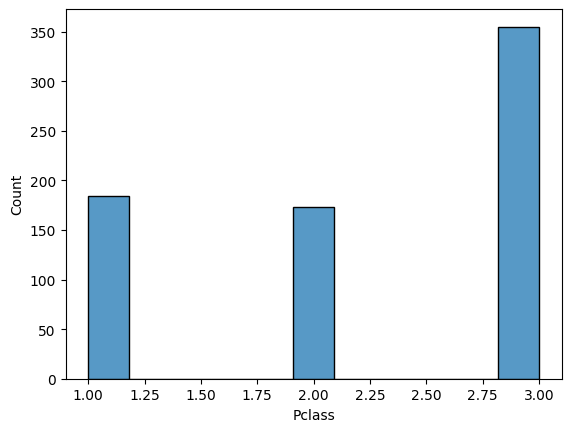

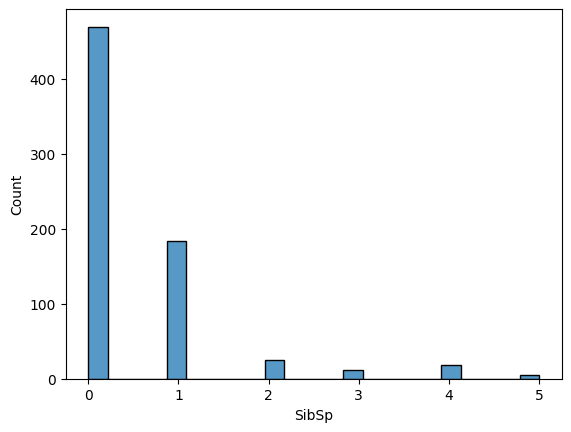

In [27]:
for i, column in enumerate(x.columns):
    plt.figure(i)
    sns.histplot(x[column])

In [44]:
x.loc[0].to_numpy().shape

(7,)

In [43]:
classifier.predict(x.loc[0].to_numpy().reshape(1, -1))

c:\Users\kaush\anaconda3\envs\flask_deploy\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([0], dtype=int64)

In [59]:
# prediction function
def ValuePredictor(to_predict_list):
	to_predict = np.array(to_predict_list).reshape(1, -1)
	loaded_model = joblib.load(open(config.default_model, "rb"))
	result = loaded_model.predict(to_predict)
	return result[0]




In [60]:
ValuePredictor(x.loc[0])

0

In [61]:
from flask import Flask

app = Flask(__name__)

@app.route('/result', methods = ['POST'])
def result():
	if request.method == 'POST':
		to_predict_list = request.form.to_dict()
		to_predict_list = list(to_predict_list.values())
		to_predict_list = list(map(int, to_predict_list))
		result = ValuePredictor(to_predict_list)	
		if int(result)== 1:
			prediction = "Congratulations, you would survive the Titanic disaster!"
		else:
			prediction = "Sorry, you wouldn't make it out alive :("		
		return render_template("result.html", prediction = prediction)